In [6]:
# Data Organisation and Visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pathlib
import csv

# SciKit Learn Feature Selection and Data Split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn import metrics  # metrics.mean_squared_error, metrics.r2_score

# SciKit Learn Machine Learning Libraries
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression  #Set 1, Model 1
from sklearn.linear_model import SGDClassifier, SGDRegressor   #Set 1, Model 1
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier  #Set 1, Model 2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  #Set 1, Model 2
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier  #Set 1, Model 2

# PyTorch and fast.ai Machine Learning Libraries
import torch.nn as nn  #contains neural network layer methods
import torch.nn.functional as F  #specifically convolutional layer methods
import torch.optim as optim  #pytorch optimization algorithms
from fastai.tabular import *  #Used in Set 2, Model 1 & 2 experiments

# Miscellaneous
import random  #random number generation used for testing
import time  #timing individual sections of code
#from tqdm.notebook import tqdm  #progress bar for 'for loops'
from datetime import datetime  #accurate time stamp indexing

In [7]:
def pull_nasdaq100(path, tp):
    filename = 'nasdaq100.csv'
    data = pd.read_csv(path/filename) #pull data from filename
    j=1
    for i in reversed(tp):
        k = str(i/390)
        #CREATE STAGGERED TARGET COLUMN  (REGRESSION TARGET)
        target_list = data[target].tolist()  #creates list from target column
        target_list.extend([np.nan for x in range(i)])  #extends list with NaNs for specified time period
        target_list = target_list[i:]  #cuts the list back to size

        #CREATE UP/DOWN TARGET COLUMN  (CLASSIFICATION TARGET)
        classification_list = []
        for i in range(len(target_list)):
            if target_list[i] >= data['NDX'][i]:  item = 1
            else:  item = 0
            classification_list.append(item)
        
        data.insert(0, 'Classification Target: +'+k+' Days', classification_list) #insert
        data.insert(0+j, 'Regression Target: +'+k+' Days', target_list) #insert
        j+=1 
    return data.dropna()  #remove rows with NaN


def feature_selection(data, num_features, mode):
    #mode either classif or regress
    #split full df into x and y, feature select, to df then rejoin  -  we lose data in column names, but that's ok
    columns,index = data.columns.to_list(), data.index.values  #extract columns and index of x
    if mode == "classification":
        data = data.drop(data.columns[range(10,20)], axis=1)  #drop the regression targets
        X,y = data.drop(data.columns[range(0,10)], axis=1), data[data.columns[range(0,10)]]
        X = SelectKBest(mutual_info_classif, k=num_features).fit_transform(X,y.iloc[:,0])  #this reduces input features
        
    if mode == "regression":
        data = data.drop(data.columns[range(0,10)], axis=1)  #drop the classification targets
        X,y = data.drop(data.columns[range(0,10)], axis=1), data[data.columns[range(0,10)]]
        X = SelectKBest(mutual_info_regression, k=num_features).fit_transform(X,y.iloc[:,0])  #this reduces input features
    
    X = pd.DataFrame(X, index=index)
    data = pd.concat([y, X], axis=1, sort=False)
    return data


def sequence_input(data, sequence_length, sequence_spacing):
    df_main, df_x = data.iloc[:,:10], data.iloc[:,10:]
    nan_unit = pd.DataFrame(np.nan, columns=df_x.columns, index=range(sequence_spacing)) #create nan row df
    y_cols = df_main.columns.tolist()

    for i in range(sequence_length):  #for i we create and concat a new temp_x
        nan_block = nan_unit.iloc[:0, :]  #create 
        for j in range(i):   #create nan block to add to start of temp_x
            nan_block = pd.concat([nan_block, nan_unit], ignore_index=True)
        temp_x = pd.concat([nan_block, df_x], ignore_index=True)  #make overlength x
        df_main = pd.concat([df_main, temp_x], axis=1, ignore_index=True)
        df_cols = y_cols + list(range(len(df_main.columns)-10))
        df_main.columns = df_cols
    return df_main.dropna()

   

def split(data):   #split data into train, valid and test sets
    data_train, data_test = data[:-5000], data[-5000:]
    return data_train, data_test


def scale(data_train, data_test):
    #set up normalization on train, apply to valid and test
    train_x = data_train.iloc[:, 10:]  #pull x values from train data
    scaler = preprocessing.StandardScaler().fit(train_x) #fit scale model to train set
    
    data, scaled_data = [data_train, data_test], []
    for df in data:
        df_y, df_x = df.iloc[:, :10], df.iloc[:, 10:]  #splits data into y and x columns
        columns,index = df_x.columns.to_list(), df_x.index.values  #extract columns and index of x
        x_scaled = scaler.transform(df_x)  #returns np.array
        df_x = pd.DataFrame(x_scaled, columns=columns, index=index)
        df = pd.concat([df_y, df_x], axis=1, sort=False)
        scaled_data.append(df)
        
    return scaled_data[0], scaled_data[1]  #train, valid, test


def truncate(data, n_rows):
    #REDUCE df_nasdaq100 INTO THE SMALLER dataframe        
    data = data.iloc[-n_rows:]
    return data


def split_Xy(data_train, data_test):
    data_list = [data_train, data_test]
    X_list, y_list = [], []
    for data in data_list:  X_list.append(data.iloc[:, 10:]), y_list.append(data.iloc[:, :10])
    return [X_list[0],y_list[0]],  [X_list[1],y_list[1]]



#SCORE AND GRAPHING FUNCTIONS

def score_classif(model, target, predicted): #score classification result
    tested,correct = 0,0
    for i in range(len(target)):
        if   target[i] == predicted[i]: correct,tested = correct+1,tested+1
        elif target[i] != predicted[i]: tested +=1
    print(model + " Classification Score: ", (correct/tested)*100)

    
def score_regress(target, prediction):  #target is as a series, prediciton is as an np.array
    for i in range(1, len(target)):
        score_list  = [metrics.r2_score(target, prediction),
                       np.sqrt(metrics.mean_squared_error(target, prediction))]  # [r2, mse]
    return score_list


def plot_col(targ, pred, col):  #pring regression results
    #plot specified columns in pred vs. targ
    x_axis = list(range(len(df_test)))
    # Data for plotting

    for i in range(len(col)):
        fig, a = plt.subplots()  #1,len(col))
        a.plot(x_axis, targ.iloc[:, col[i]], label='NDX^ Target Value')
        a.plot(x_axis, pred.iloc[:, col[i]], label='NDX^ Predicted Value')
        a.set(xlabel='Test Dataset Index', ylabel='NDX^ Value',
              title='Forecast: +'+str((tp[col[i]-1])/390)+' Days')
        a.legend(loc='upper right')
        #plt.tight_layout()
        plt.show()


def plot_row(targ, pred, row):
    fig = go.Figure()
    x_axis = ['NDX Base Truth']
    for i in pred.columns.tolist()[1:]: x_axis.append(i.split(" ", 2)[2])

    for j in range(len(row)):
        fig, a = plt.subplots() #1,len(row))
        a.plot(x_axis, targ.iloc[row[j]], label='NDX^ Target Value')
        a.plot(x_axis, pred.iloc[row[j]], label='NDX^ Predicted Value')
        a.set(xlabel='Time (Days)', ylabel='NDX^ Value',
              title='0.5-5 Day Forecast: Row Index: '+str(row[j]))
        a.legend(loc='upper right')
        a.set_xticklabels(x_axis, rotation=40, ha='right')
        plt.show()


In [8]:
filename = 'nasdaq100.csv'     # data file to be used
#path = pathlib.Path.home()/'OneDrive'/'19-20 3rd Yr MEng'/'Dissertation'/'Data'/'NASDAQ-100 II'
path = pathlib.Path.cwd()  #path for salamander.ai
target = 'NDX'  #target column name to be predicted

data_norm = True
data_redu = True
tp1  = [39, 78, 117, 156, 195, 234, 273, 312, 351, 390]  #10 models up to 1 day
tp5  = [195, 390, 585, 780, 975, 1170, 1365, 1560, 1755, 1950]  #10 models up to 5 days
tp10 = [390, 780, 1170, 1560, 1950, 2340, 2730, 3120, 3510, 3900]  #10 models up to 10 days

tp = tp5

In [ ]:
df_full = pull_nasdaq100(path, tp)

#graph data
x_axis = list(range(len(df_full)))
y_ndx = df_full['NDX']

#targets
fig = go.Figure()
fig.add_shape(dict(type="line",x0=len(df_full)-5000,y0=4600,x1=len(df_full)-5000,y1=5000,line=dict( color="Red", width=1)))
fig.add_trace(go.Scatter(x=x_axis, y=y_ndx, fill=None, mode='lines', name='NDX^ Price'))
for column in df_full.columns.tolist()[10:20]:
    fig.add_trace(go.Scatter(x=x_axis, y=df_full[column], fill=None, mode='lines', name=column))
fig.update_layout(title="NASDAQ100 NDX^:  July 26th to December 22nd 2016", xaxis_title="Time", yaxis_title="NDX^ value")
fig.show()


#inputs
fig = go.Figure()
fig.add_shape(dict(type="line",x0=len(df_full)-5460,y0=0,x1=len(df_full)-5460,y1=200,line=dict( color="Red", width=1)))
for column in df_full.columns.tolist()[20:]:
    fig.add_trace(go.Scatter(x=x_axis, y=df_full[column], fill=None, mode='lines', name=column))
fig.update_layout(title="NASDAQ100 NDX^:  July 26th to December 22nd 2016", xaxis_title="Time", yaxis_title="NDX^ value")
fig.show()

In [ ]:



########################################

## SET 2

########################################




In [ ]:
#####
## REGRESSION
#####

In [9]:
input_features = 20
data_rows = 30000
layers = [500,500,500]  #neural net hidden layer arrangement
s2_m1 = []  #list that will be appended with experiment results

for input_features in [50]:
    for data_rows in [30000]:
        tag = str(data_rows)+" "+str(input_features)  #what experiment is this?
        
        #CREATE REGRESSION DATA SETS
        df_full = pull_nasdaq100(path, tp)  #import data with y_c and y_r cols
        df_selected = feature_selection(df_full, input_features, 'regression')  #reduce columns and cut classif
        df_train, df_test = split(df_selected)  #split train/test
        df_train, df_test = scale(df_train, df_test)  #normalize and scale data
        df_train = truncate(df_train, data_rows)
        #train_R, test_R = split_Xy(df_train, df_test)  #split data betwen X & y

        count = 0
        
        s2_m1_list=[]  #iterations for averaging appended to this list
        for itt in range(5):
            #params for databunch
            df = df_train  #df is train and validation combined
            valid_idx = range(int(0.8*data_rows),data_rows)  #validation range within df
            test_df = df_test
            bs=64
            train_metrics = [r2_score, root_mean_squared_error]

            #CREATE LIST OF LEARNERS, ONE PER ITEM IN TP
            input_list = df_train.columns.tolist()[10:]   #isolate inputs
            target_list = df_train.columns.tolist()[:10]   #isolate targets
            learner_list = []   #to be appended to with learners
            i = 0
            for column in target_list:   #number of models we're going for
                df = pd.concat([df_train[column], df_train[input_list]], axis=1, sort=False)
                data = TabularDataBunch.from_df(path, df=df, dep_var=column, valid_idx=valid_idx, bs=bs)
                learner_list.append(tabular_learner(data, layers=layers, metrics=train_metrics))  #create learner


            #Train Phase 1
            for learn in learner_list:
                learn.fit_one_cycle(6,3e-3)  #fast train initially
            print("all models trained for iteration ", itt+1 , "!")

            #Create prediction and target dataframes
            ndx_df = pd.DataFrame(df_full['NDX'])  #create df with just ndx
            ndx_df.rename(columns={"NDX": "NDX Base Truth"})  #rename ndx column

            df_targ = pd.concat([ndx_df, df_test.iloc[:, :10]], axis=1).dropna()  #creates target dataframe, dropna to remove excess ndx
            df_pred = df_targ.iloc[:, :1]  #just ndx column, will be added to later on
            df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df

            X = df_test.iloc[:, 10:]  #isolates inputs from test dataframe
            i = 0  #ticker indicates the half days
            for learn in learner_list:
                y_pred = []  #every predicted value is appended to this list
                for j in range(0, len(df_test)):  #run through length of test_df
                    y = learn.predict(X.iloc[j])[1]  # calls the current colmn
                    y_pred.append(y.item())  #extract value from torch.tensor and append to test
                df_pred.insert(len(df_pred.columns), 'Regression Prediction: +'+str(tp[i]/390)+' Days', y_pred)

                score = score_regress(df_targ.iloc[:, i+1], y_pred)  #score model  (series, np.array)
                df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df    
                i +=1

            s2_m1_list.append([df_targ, df_pred, df_score])
            print(itt+1 , " Complete!")  

        #####################

        #AVERAGE RESULTS OF ALL 5 ITERATIONS
        averaged_pred = pd.DataFrame(0, index=range(len(s2_m1_list[0][1])), columns=s2_m1_list[0][1].columns)
        for i in range(len(s2_m1_list[0][1].columns)):  #go through each column
            for j in range(len(s2_m1_list[0][1].iloc[:,0])):  #go through each element in the column
                val = 0  #this will be summed up
                for k in range(len(s2_m1_list)):
                    val += s2_m1_list[k][1].iloc[j,i]
                val = val/len(s2_m1_list)  #averagted out
                averaged_pred.iloc[j,i] = val   #swap av_pred value with val

        df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df
        for i in range(len(averaged_pred.columns[1:])):
            score = score_regress(df_targ.iloc[:, i+1], averaged_pred.iloc[:,i+1])  #score model  (series, np.array)
            df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df

        s2_m1.append([df_targ, averaged_pred, df_score, tag])
        
        print(tag + " Complete!")
    print(str(input_features)+" Complete!")

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22744692.000000,22606320.000000,-2946419.750000,4754.429199,00:03
1,13612179.000000,11873883.000000,-1556098.000000,3445.478027,00:03
2,2565801.750000,1827052.875000,-243737.296875,1350.892456,00:03
3,52653.839844,20860.787109,-3618.215576,135.084793,00:03
4,140.982727,3322.661377,-583.686401,47.880348,00:03
5,73.356750,3949.712646,-755.500610,51.749359,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22731882.000000,22891108.000000,-3144126.500000,4784.258789,00:03
1,13613126.000000,12437185.000000,-1717497.125000,3526.280029,00:03
2,2568140.750000,1948321.625000,-273394.531250,1395.081787,00:03
3,52477.675781,42977.156250,-6435.310547,204.167496,00:03
4,128.286560,7668.255859,-1459.211792,74.174698,00:03
5,61.396290,5021.986816,-844.039062,62.358093,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22722404.000000,23218116.000000,-3393447.500000,4818.074219,00:03
1,13595329.000000,11868699.000000,-1730659.875000,3444.239014,00:03
2,2566117.000000,1641821.000000,-243343.140625,1278.493042,00:03
3,51978.285156,14577.504883,-1777.110107,96.669899,00:03
4,143.640518,11238.463867,-878.335327,92.154427,00:03
5,78.072289,9532.239258,-649.623291,81.367844,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22713162.000000,23305214.000000,-3580002.750000,4827.247070,00:03
1,13591050.000000,11826773.000000,-1810493.125000,3438.466064,00:03
2,2560884.750000,1595567.750000,-237490.203125,1260.847046,00:03
3,52326.507812,12638.054688,-1586.456543,96.474022,00:03
4,130.762756,3199.184326,-156.299484,43.386036,00:03
5,56.307438,3297.072754,-179.564392,44.419094,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22708272.000000,22610788.000000,-3596802.500000,4754.749512,00:03
1,13595238.000000,12025385.000000,-1913803.125000,3467.439453,00:03
2,2563910.250000,1752200.250000,-283985.906250,1322.464233,00:03
3,52183.085938,12018.458984,-1973.968628,100.318863,00:03
4,160.881683,3893.333252,-453.173279,55.736546,00:03
5,94.328506,2997.802246,-292.100769,48.091667,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22703870.000000,22446564.000000,-3202604.250000,4737.571289,00:03
1,13591410.000000,11917266.000000,-1714085.500000,3451.792236,00:03
2,2561523.000000,1646186.500000,-236989.437500,1282.415894,00:03
3,52231.035156,7129.521484,-830.643860,74.886742,00:03
4,144.104416,13917.205078,-2238.060547,105.027573,00:03
5,72.007690,12587.389648,-1978.959106,99.595139,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22706264.000000,22787260.000000,-3072624.750000,4773.293945,00:03
1,13585041.000000,11927160.000000,-1618330.250000,3453.196777,00:03
2,2558125.500000,1776944.500000,-247432.812500,1332.106934,00:03
3,52214.152344,33388.664062,-6347.554199,171.073074,00:03
4,164.227493,8492.652344,-1828.510864,77.228249,00:03
5,89.789925,9258.297852,-1986.892822,80.821785,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22701612.000000,22495184.000000,-3142984.250000,4742.645996,00:03
1,13581646.000000,11985621.000000,-1683860.125000,3461.631104,00:03
2,2561911.500000,1814471.875000,-262107.265625,1345.974609,00:03
3,52120.597656,22179.476562,-4406.063965,138.230591,00:03
4,144.695801,2363.364502,-289.204010,42.375347,00:03
5,59.825790,2866.529297,-438.586487,47.465401,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22705990.000000,22487670.000000,-3218490.250000,4741.855957,00:03
1,13589796.000000,11649797.000000,-1674662.000000,3412.829590,00:03
2,2560102.750000,1729825.125000,-250939.781250,1314.199951,00:03
3,52016.546875,12277.962891,-2243.513916,98.804497,00:03
4,166.443649,3337.949951,-330.833649,45.804401,00:03
5,86.961479,3668.395020,-379.137756,48.699661,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22709164.000000,22190256.000000,-3129917.500000,4710.373535,00:03
1,13586783.000000,11513194.000000,-1629385.375000,3392.757568,00:03
2,2559524.750000,1713409.750000,-251231.281250,1307.369507,00:03
3,52237.351562,8796.065430,-1870.821655,78.473701,00:03
4,136.814041,3959.177246,-332.828583,54.319370,00:03
5,78.060364,4030.114258,-321.812317,53.803860,00:03


all models trained for iteration  1 !
1  Complete!


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22742002.000000,22932232.000000,-2989593.250000,4788.453125,00:03
1,13616890.000000,12509936.000000,-1652611.750000,3535.953613,00:03
2,2568671.000000,1990919.875000,-273518.250000,1408.266113,00:03
3,52325.949219,53747.820312,-8905.112305,216.102585,00:03
4,152.394867,30106.207031,-4616.442383,154.544006,00:03
5,71.928162,37649.308594,-5589.311035,172.462677,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22728730.000000,23260252.000000,-3199279.500000,4822.641602,00:03
1,13602867.000000,12525926.000000,-1730706.250000,3538.784912,00:03
2,2565093.250000,2048852.125000,-292024.593750,1429.894043,00:03
3,52329.972656,43200.253906,-6966.732910,201.941360,00:03
4,127.116943,14387.536133,-2611.316895,110.889748,00:03
5,60.725338,15376.161133,-2818.868652,114.261238,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22724442.000000,23202194.000000,-3392058.750000,4816.523926,00:03
1,13597349.000000,12366481.000000,-1812688.500000,3516.264893,00:03
2,2562832.750000,1980293.750000,-303831.562500,1404.870728,00:03
3,52642.773438,39035.542969,-7148.567871,188.573013,00:03
4,146.590057,9069.265625,-1590.422485,80.976669,00:03
5,79.404694,7484.061523,-1230.159790,73.169983,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22720194.000000,22822644.000000,-3495496.000000,4776.963867,00:03
1,13597188.000000,11943278.000000,-1827412.125000,3455.407715,00:03
2,2561101.000000,1808263.125000,-285768.843750,1343.371216,00:03
3,52266.976562,27416.972656,-5096.164551,153.482666,00:03
4,147.783173,14072.882812,-3084.213379,103.046097,00:03
5,72.465607,12672.962891,-2715.618652,97.971420,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22713306.000000,22638682.000000,-3598157.500000,4757.701172,00:03
1,13593496.000000,11831827.000000,-1886984.250000,3439.343262,00:03
2,2561219.750000,1799495.500000,-294410.125000,1340.303223,00:03
3,52266.625000,45915.457031,-9820.854492,197.180435,00:03
4,147.154861,33571.386719,-7853.025391,150.743576,00:03
5,92.000114,37937.332031,-8853.205078,160.424576,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700380.000000,23063628.000000,-3317894.750000,4802.027344,00:03
1,13587408.000000,12132646.000000,-1756655.250000,3482.497559,00:03
2,2560725.250000,1587593.375000,-222592.015625,1258.845825,00:03
3,51976.714844,27544.031250,-5720.206055,154.502090,00:03
4,136.216736,10625.103516,-1622.256348,90.526855,00:03
5,64.519043,41859.792969,-7573.068848,179.392349,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22707210.000000,22777806.000000,-3071974.500000,4772.345215,00:03
1,13588264.000000,12042161.000000,-1635644.125000,3469.744385,00:03
2,2558638.500000,1896070.875000,-266939.656250,1375.669434,00:03
3,52221.394531,19076.427734,-3262.386230,130.877319,00:03
4,161.797256,2177.622559,-336.387909,40.281696,00:03
5,83.193611,2389.506592,-368.233704,42.062103,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22710212.000000,22488232.000000,-3136662.500000,4741.956543,00:03
1,13588429.000000,11619286.000000,-1621292.750000,3408.438721,00:03
2,2559440.250000,1679013.000000,-236626.625000,1295.032349,00:03
3,52319.324219,6660.563477,-1230.898804,74.797539,00:03
4,126.776207,3171.849121,-234.433395,42.818829,00:03
5,69.546532,5392.747559,-428.913239,55.986404,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700080.000000,22193768.000000,-3177551.250000,4710.717773,00:03
1,13584232.000000,11109939.000000,-1577151.500000,3332.681396,00:03
2,2558559.500000,1785019.875000,-266173.625000,1334.516113,00:03
3,52328.792969,65550.179688,-13545.504883,233.956833,00:03
4,161.335373,12616.864258,-2797.923340,91.372345,00:03
5,96.144875,15205.841797,-3387.828369,103.065689,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700874.000000,22109256.000000,-3125294.750000,4701.734863,00:03
1,13588952.000000,11584060.000000,-1645943.625000,3403.053955,00:03
2,2560091.000000,1697327.125000,-248649.812500,1301.379883,00:03
3,52075.011719,32007.406250,-6032.061523,157.237411,00:03
4,146.985229,5581.589355,-657.491333,64.281242,00:03
5,74.798737,5081.063965,-536.539490,59.871731,00:03


all models trained for iteration  2 !
2  Complete!


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22737814.000000,22976776.000000,-2999328.750000,4793.041504,00:03
1,13611848.000000,11915802.000000,-1553778.875000,3451.721680,00:03
2,2566075.500000,1709768.500000,-225559.640625,1307.142700,00:03
3,52721.031250,15917.062500,-3006.310547,114.096115,00:03
4,146.823151,2359.703369,-154.891510,39.150314,00:03
5,82.565071,2989.808105,-210.630295,44.685135,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22732122.000000,22744394.000000,-3121699.750000,4768.917480,00:03
1,13607045.000000,12311429.000000,-1692906.375000,3508.536377,00:03
2,2565642.250000,1917828.750000,-269629.875000,1384.026978,00:03
3,52615.605469,40444.390625,-6492.131348,196.609024,00:03
4,126.318588,11012.258789,-2151.602295,92.898262,00:03
5,64.351852,9540.440430,-1748.554810,88.570274,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22722122.000000,23136964.000000,-3382783.750000,4809.707520,00:03
1,13603595.000000,12653732.000000,-1875618.625000,3556.214600,00:03
2,2561217.000000,1912792.375000,-291899.312500,1380.776001,00:03
3,52476.781250,33189.039062,-6632.043457,159.216629,00:03
4,149.556534,5754.033203,-570.374817,68.336090,00:03
5,81.719948,5588.270508,-725.051819,67.771706,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22713636.000000,23265876.000000,-3569929.250000,4823.217773,00:03
1,13596760.000000,12151300.000000,-1866558.125000,3485.512939,00:03
2,2562390.000000,1954840.750000,-311600.562500,1396.690918,00:03
3,52371.777344,57392.980469,-11584.351562,227.619797,00:03
4,132.193298,10096.943359,-1998.063965,91.658073,00:03
5,76.593460,13859.828125,-2878.430420,105.685501,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22709532.000000,22812958.000000,-3624737.750000,4775.877441,00:03
1,13590296.000000,11714292.000000,-1853298.750000,3422.053711,00:03
2,2561314.750000,1677624.625000,-267964.593750,1294.288940,00:03
3,52200.183594,14063.778320,-2483.773193,107.901413,00:03
4,152.844452,3740.466064,-230.870667,45.439186,00:03
5,75.847656,3642.867920,-233.587097,45.858894,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22703756.000000,22795044.000000,-3263569.500000,4774.128906,00:03
1,13589122.000000,12104988.000000,-1743412.250000,3478.777344,00:03
2,2560298.000000,1752727.375000,-258405.671875,1323.005127,00:03
3,52100.308594,28546.523438,-5613.296875,157.206314,00:03
4,140.905258,15603.203125,-3513.139648,105.165749,00:03
5,69.282028,13029.046875,-2947.261719,94.935814,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22706228.000000,23042610.000000,-3116157.500000,4799.893555,00:03
1,13589233.000000,12151278.000000,-1654020.625000,3485.383545,00:03
2,2559549.250000,1953382.875000,-276024.312500,1395.937378,00:03
3,51833.222656,33315.742188,-6017.669922,173.462372,00:03
4,164.617630,9136.624023,-1940.044678,79.660919,00:03
5,84.864059,11968.266602,-2524.872559,91.237564,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22705190.000000,22348988.000000,-3115139.000000,4727.248535,00:03
1,13593802.000000,11851695.000000,-1666415.125000,3442.221436,00:03
2,2557959.000000,1674169.625000,-239148.968750,1293.028564,00:03
3,52355.507812,9387.715820,-1719.481812,90.494637,00:03
4,133.923065,4931.173828,-439.756195,55.413525,00:03
5,69.052147,4860.104980,-421.692169,54.059921,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22693202.000000,22465108.000000,-3226119.250000,4739.387695,00:03
1,13585894.000000,11813332.000000,-1700849.875000,3436.662109,00:03
2,2558599.500000,1651959.000000,-238659.609375,1284.706787,00:03
3,52198.492188,12574.733398,-2341.159424,101.658867,00:03
4,160.832962,2793.801270,-469.887878,45.308777,00:03
5,89.238922,2000.366699,-249.096832,37.143208,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22709578.000000,22308034.000000,-3152867.750000,4722.827637,00:03
1,13583937.000000,11603343.000000,-1647603.750000,3405.909668,00:03
2,2561250.750000,1619971.375000,-235181.390625,1271.763672,00:03
3,51969.531250,9561.689453,-1859.611450,83.133720,00:03
4,134.330826,7650.251465,-636.335693,74.682976,00:03
5,80.403053,11227.430664,-1101.793701,95.194565,00:03


all models trained for iteration  3 !
3  Complete!


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22741936.000000,22585148.000000,-2939703.000000,4752.194824,00:03
1,13607820.000000,11860879.000000,-1544724.875000,3443.779297,00:03
2,2567513.000000,1833091.125000,-241723.453125,1353.264526,00:03
3,52611.289062,21817.146484,-3496.695068,141.538071,00:03
4,154.310699,57847.464844,-13418.354492,154.945221,00:03
5,88.606827,44477.601562,-10347.911133,133.452438,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22733016.000000,23330494.000000,-3212724.250000,4829.829590,00:03
1,13601950.000000,12440547.000000,-1720689.875000,3526.658936,00:03
2,2567807.250000,2025512.500000,-284792.156250,1422.194214,00:03
3,52492.308594,66129.210938,-10572.241211,249.699066,00:03
4,124.351242,18280.531250,-3046.145752,124.865700,00:03
5,68.793587,13666.740234,-2304.034424,107.025024,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22722444.000000,23104346.000000,-3379974.500000,4806.331543,00:03
1,13601239.000000,11614806.000000,-1685140.875000,3407.393555,00:03
2,2561683.750000,1500788.000000,-205208.953125,1219.895630,00:03
3,52396.066406,12355.287109,-1338.819214,86.097824,00:03
4,148.492599,7657.203125,-662.590515,76.942932,00:03
5,76.299736,13804.625000,-1544.897461,108.827301,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22717894.000000,22960202.000000,-3524170.500000,4791.327148,00:03
1,13588220.000000,11951890.000000,-1830438.250000,3456.657227,00:03
2,2560567.750000,1812411.375000,-281824.156250,1345.032104,00:03
3,52463.398438,25398.544922,-4195.121582,149.350998,00:03
4,132.499664,4525.837891,-385.839905,56.778217,00:03
5,65.971176,4317.263184,-436.284821,56.947868,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22711674.000000,22747962.000000,-3624471.500000,4769.157227,00:03
1,13592242.000000,12147341.000000,-1942534.375000,3484.814941,00:03
2,2557938.750000,1823203.000000,-295394.125000,1349.408203,00:03
3,52269.964844,29172.626953,-6046.909180,161.153412,00:03
4,150.031433,2765.512451,-533.892578,46.468548,00:03
5,85.348579,2438.816406,-435.173126,42.915974,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22701400.000000,23020064.000000,-3302924.250000,4797.609863,00:03
1,13588399.000000,12115445.000000,-1744958.500000,3480.323975,00:03
2,2559473.500000,1744256.375000,-255679.281250,1319.656372,00:03
3,52209.945312,31730.021484,-6479.313477,163.078003,00:03
4,132.748138,5557.243164,-980.238403,64.534836,00:03
5,68.634590,6249.671875,-1106.369263,68.049103,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22706568.000000,22697172.000000,-3060252.000000,4763.903320,00:03
1,13589136.000000,12102021.000000,-1644632.750000,3478.356934,00:03
2,2558510.000000,1946242.500000,-275518.156250,1393.317505,00:03
3,52320.152344,57543.535156,-10824.774414,222.826630,00:03
4,159.482040,24149.570312,-4996.629395,128.973297,00:03
5,74.974579,28553.912109,-5836.185547,140.367599,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22704734.000000,22572212.000000,-3155071.750000,4750.751465,00:03
1,13581107.000000,11379511.000000,-1576040.250000,3373.035889,00:03
2,2562269.750000,1728925.500000,-248853.156250,1313.921387,00:03
3,52373.042969,21890.718750,-4386.089844,135.634415,00:03
4,140.246140,3139.026367,-305.072113,47.001740,00:03
5,58.779499,3745.051758,-633.752075,55.088177,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22706218.000000,22458116.000000,-3221367.500000,4738.704590,00:03
1,13589519.000000,11641860.000000,-1674892.250000,3411.652588,00:03
2,2561132.750000,1684824.875000,-249035.390625,1296.713013,00:03
3,52100.292969,12963.744141,-2530.303955,100.034241,00:03
4,154.782440,6664.132812,-555.096191,59.592712,00:03
5,94.590012,6507.090820,-544.381653,61.375118,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700480.000000,21805724.000000,-3079398.000000,4669.353516,00:03
1,13585657.000000,11797438.000000,-1684418.750000,3434.028320,00:03
2,2561654.750000,1733391.500000,-254113.000000,1314.752563,00:03
3,52191.765625,15557.477539,-3201.637451,106.321739,00:03
4,142.513412,4676.487793,-337.437469,56.922474,00:03
5,65.699272,5637.728516,-371.164795,59.143314,00:03


all models trained for iteration  4 !
4  Complete!


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22734712.000000,22610314.000000,-2947422.250000,4754.819336,00:03
1,13606488.000000,11973222.000000,-1562532.125000,3459.984619,00:03
2,2565113.750000,1693869.375000,-221334.062500,1301.123047,00:03
3,52492.937500,26242.494141,-4185.476562,155.582764,00:03
4,147.641907,3040.563232,-606.457886,46.274380,00:03
5,73.660103,3850.919678,-766.728088,53.098385,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22727802.000000,23161294.000000,-3184232.000000,4812.309570,00:03
1,13606840.000000,12444464.000000,-1719296.625000,3527.231934,00:03
2,2566449.000000,1890189.625000,-262205.750000,1374.268555,00:03
3,52633.300781,45882.292969,-6944.324219,210.466980,00:03
4,124.475571,8116.952637,-1168.541138,82.357109,00:03
5,67.259094,5356.866699,-719.166016,61.375851,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22720734.000000,23400378.000000,-3428427.750000,4836.890137,00:03
1,13600246.000000,12091324.000000,-1768244.875000,3476.693604,00:03
2,2562853.000000,1677534.000000,-246439.125000,1292.850464,00:03
3,52624.824219,20496.324219,-3338.385986,128.296982,00:03
4,158.080322,4549.387207,-460.203918,57.504288,00:03
5,88.410278,4465.356934,-387.352417,56.260437,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22711010.000000,22864642.000000,-3505497.000000,4781.413574,00:03
1,13596665.000000,11764179.000000,-1796051.000000,3429.290039,00:03
2,2562833.750000,1741299.500000,-267852.156250,1317.903198,00:03
3,52591.578125,25183.013672,-4111.966797,144.266556,00:03
4,137.706207,5300.020508,-692.039551,65.864418,00:03
5,78.110573,5576.665527,-812.399597,68.535782,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22711954.000000,22781708.000000,-3625795.250000,4772.652832,00:03
1,13594231.000000,11873601.000000,-1897283.250000,3445.138428,00:03
2,2561617.000000,1686479.875000,-272316.781250,1296.865234,00:03
3,52163.445312,16737.162109,-3135.761230,121.882591,00:03
4,162.426636,1577.612549,-244.842392,33.915092,00:03
5,94.881195,2561.615723,-487.202423,44.034187,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22711116.000000,22561862.000000,-3219528.250000,4749.708984,00:03
1,13588161.000000,11596732.000000,-1651110.000000,3405.134277,00:03
2,2560663.000000,1810716.625000,-267779.187500,1344.330933,00:03
3,52036.359375,54900.640625,-11375.356445,215.676590,00:03
4,139.580795,7614.554199,-1649.610840,74.971939,00:03
5,66.627769,14270.866211,-3272.043945,100.291092,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700528.000000,22786158.000000,-3066087.750000,4773.197266,00:03
1,13590863.000000,12096737.000000,-1640007.000000,3477.543701,00:03
2,2561989.750000,1888293.500000,-261275.093750,1373.262939,00:03
3,52372.101562,38883.347656,-6914.045898,187.886734,00:03
4,159.886841,11060.124023,-2289.267090,88.757622,00:03
5,82.410126,9093.717773,-1923.612305,79.828125,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22692820.000000,22814226.000000,-3197113.750000,4776.071289,00:03
1,13589165.000000,11561917.000000,-1608210.750000,3399.952637,00:03
2,2559791.000000,1675181.625000,-236938.515625,1293.492554,00:03
3,51957.984375,12175.657227,-1991.115479,102.778343,00:03
4,140.555878,2849.636230,-251.257034,39.337166,00:03
5,80.617905,2921.240723,-265.079742,40.472267,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22709792.000000,22304248.000000,-3193521.250000,4722.477539,00:03
1,13586609.000000,11714118.000000,-1687323.250000,3422.158936,00:03
2,2559130.500000,1702481.250000,-251263.937500,1303.761353,00:03
3,52311.804688,13404.599609,-2638.448730,102.801041,00:03
4,162.627335,3934.372314,-395.792847,49.029682,00:03
5,84.135605,3870.867432,-424.452240,50.943954,00:03


epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,22700718.000000,22090272.000000,-3113466.250000,4699.797852,00:03
1,13578319.000000,11647928.000000,-1657206.625000,3412.391602,00:03
2,2560413.750000,1618651.875000,-235415.531250,1271.221191,00:03
3,52110.445312,7119.060059,-1516.627319,69.410400,00:03
4,138.720078,6412.810547,-469.839172,64.666824,00:03
5,74.381569,6942.043945,-499.421051,67.646584,00:03


all models trained for iteration  5 !
5  Complete!
30000 50 Complete!
50 Complete!


30000 50


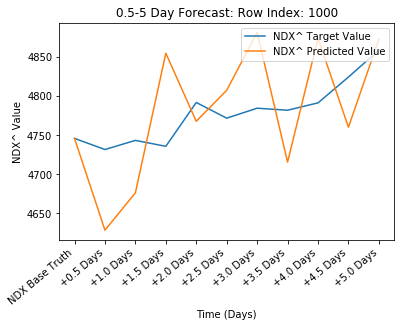

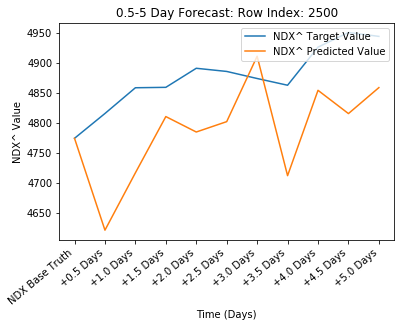

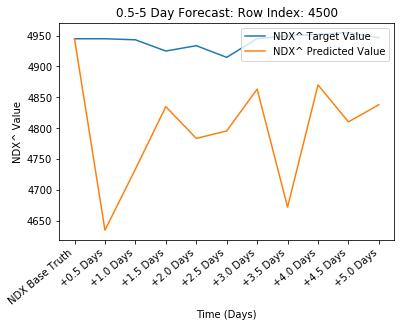

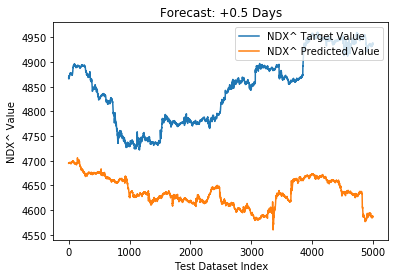

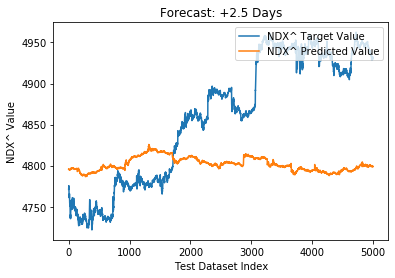

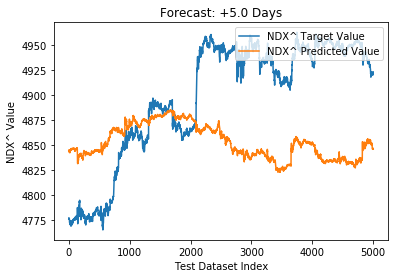

                     0.5 Days    1.0 Days   1.5 Days   2.0 Days   2.5 Days  \
R^2 Score           -8.839714   -2.567441  -0.420819  -0.643769  -0.609321   
Mean Square Error  222.733555  136.843416  87.353849  96.598886  97.366055   

                    3.0 Days    3.5 Days   4.0 Days    4.5 Days   5.0 Days  
R^2 Score          -0.021208   -6.218253   0.010023   -2.302883  -0.757773  
Mean Square Error  76.035823  193.517606  67.816001  115.041486  79.224474  

-----
-----



In [10]:
#I'm still sat here with df_targ, df_pred, df_score, plus all the 
for i in range(len(s2_m1)):
    df_targ, df_pred, df_score, tag = s2_m1[i]
    print(tag)
    plot_row(df_targ, df_pred, [1000,2500,4500])  #plot row
    plot_col(df_targ, df_pred, [1,5,10])  #plots predictions over time series
    print(df_score)
    print("\n-----\n-----\n")

In [ ]:





#####
## REGRESSION  Set 2, Model 2
#####





In [ ]:
#default test conditions
input_features = 20
data_rows = 30000
seq_len = 2
seq_sep = 200
layers = [1000,1000,1000,1000]
s2_m2 = []  #this will contain all 9 experiments  [targ, pred, score, tag]


for input_features in [80]: 
    for data_rows in [10000,20000,30000]:  
        tag = str(data_rows)+" "+str(input_features)  #what experiment is this?

        
        #CREATE REGRESSION DATA SETS
        df_full = pull_nasdaq100(path, tp)  #import data with y_c and y_r cols
        df_mod1 = feature_selection(df_full, input_features, 'regression')  #reduce columns and cut classif
        df_mod2 = sequence_input(df_mod1, seq_len, seq_sep)
        df_train, df_test = split(df_mod2)  #split train/valid/test
        df_train, df_test = scale(df_train, df_test)  #normalize and scale data
        df_train = truncate(df_train, data_rows)
        #train_R, test_R = split_Xy(df_train, df_test)  #split data betwen X & y
        
        count = 0
        s2_m2_list = []  #needs to reset before every 5 iteratiosn are run
        for itt in range(5):  #a single experiment is run 5 times, the predictions averaged from there 
                
                #params for databunch
                df = df_train  #df is train and validation combined
                valid_idx = range(int(0.8*data_rows),data_rows)  #validation range within df: 80/20
                test_df = df_test
                bs=64
                train_metrics = [r2_score, root_mean_squared_error]

                #CREATE LIST OF LEARNERS, ONE PER ITEM IN TP
                input_list = list(range(10, len(df_train.columns)))   #isolate inputs in col .iloc form
                target_list = df_train.columns.tolist()[:10]   #isolate targets
                learner_list = []   #to be appended to with learners
                #i = 0
                for column in target_list:   #create 10 learning models, add them to learner list
                    df_temp = pd.concat([df_train[column], df_train.iloc[:, input_list]], axis=1, sort=False, ignore_index=False)  #unique indices for each col
                    data = TabularDataBunch.from_df(path, df=df_temp, dep_var=column, valid_idx=valid_idx, bs=bs)
                    learner_list.append(tabular_learner(data, layers=layers, metrics=train_metrics))  #create learner



                #Train Phase
                for learn in learner_list:  #train the 10 learning models
                    learn.fit_one_cycle(6,3e-3)  #fast train
                print("all models trained for experiment: "+tag+",  iteration: ", itt+1 , "!")


                #Create prediction and target dataframes
                ndx_df = pd.DataFrame(df_full['NDX'])  #create df with just ndx
                ndx_df.rename(columns={"NDX": "NDX Base Truth"})  #rename ndx column

                df_targ = pd.concat([ndx_df, df_test.iloc[:, :10]], axis=1).dropna()  #creates target dataframe, dropna to remove excess ndx
                df_pred = df_targ.iloc[:, :1]  #just ndx column, will be added to later on
                df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df

                X = df_test.iloc[:, 10:]  #isolates inputs from test dataframe
                i = 0  #ticker indicates the half days
                for learn in learner_list:
                    y_pred = []  #every predicted value is appended to this list
                    for j in range(0, len(df_test)):  #run through length of test_df
                        y = learn.predict(X.iloc[j])[1]  #
                        y_pred.append(y.item())  #extract value from torch.tensor and append to test
                    df_pred.insert(len(df_pred.columns), 'Regression Prediction: +'+str(tp[i]/390)+' Days', y_pred)

                    score = score_regress(df_targ.iloc[:, i+1], y_pred)  #score model  (series, np.array)
                    df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df    
                    i +=1

                s2_m2_list.append([df_targ, df_pred, df_score, tag]) #contains all results 
                print(itt+1 , " Complete!")       
        ## this experiment has now been run 5 times, will be averaged into 1 df
        #############################
        
        #Create averaged table
        averaged_pred = pd.DataFrame(0, index=range(len(s2_m2_list[0][1])), columns=s2_m2_list[0][1].columns)
        for i in range(len(s2_m2_list[0][1].columns)):  #for each column
            for j in range(len(s2_m2_list[0][1].iloc[:,0])):  #for each row
                val = 0  #this will be summed up
                for k in range(len(s2_m2_list)):
                    val += s2_m2_list[k][1].iloc[j,i]
                val = val/len(s2_m2_list)  #averagted out
                averaged_pred.iloc[j,i] = val   #swap av_pred value with val

        df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df
        for i in range(len(averaged_pred.columns[1:])):
            score = score_regress(df_targ.iloc[:, i+1], averaged_pred.iloc[:,i+1])  #score model  (series, np.array)
            df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df

        s2_m2.append([df_targ, averaged_pred, df_score, tag])  #add this exp to s2_m2
        print("averaged table created")
        print(tag + " Complete!")
    print(str(input_features)+" Complete!")            
            

In [ ]:
df_temp

In [ ]:
#I'm still sat here with df_targ, df_pred, df_score, plus all the 
for i in range(len(s2_m2)):
    df_targ, df_pred, df_score, tag = s2_m2[i]
    print(tag)
    plot_row(df_targ, df_pred, [1000,2500,4500])  #plot row
    plot_col(df_targ, df_pred, [1,5,10])  #plots predictions over time series
    print(df_score)
    print("\n-----\n-----\n")

In [ ]:




















## 
#old

In [ ]:
#####
## Classification
#####

#CREATE CLASSIFICATION DATA SETS
'''df = feature_selection(df_full, input_features, 'classification')  #reduce columns
df_train, df_test = split(df)  #split train/valid/test
#df_train, df_test = scale(df_train, df_test)  #normalize and scale data
df_train = truncate(df_train, data_rows)
#train_C, test_C = split_Xy(df_train, df_test)

#FORMAT df_nasdaq100 AS FAST.AI DATABUNCH
df = df_train  #df is train and validation combined
dep_var = df.columns[0]
valid_idx = range(-2730,-1)  #validation range within df
procs = [Normalize]
test_df = df_test
bs=64

#FORMAT DATA AS FAST.AI DATABUNCH
data = TabularDataBunch.from_df(path, df=df, dep_var=dep_var, valid_idx=valid_idx,
                                procs=procs, test_df=test_df, bs=bs)

#LEARNER and Train Stage 1
learn = tabular_learner(data, layers=[1000,500])
learn.fit_one_cycle(5,3e-3)


#LR Finder
learn.lr_find()
learn.recorder.plot()


#Train Stage 2
learn.fit_one_cycle(5,3e-3)

df_pred = test_df.iloc[:, :1]  #create df_pred
y_test = df_test.iloc[:, 0].values.tolist()

y_pred = []
for i in range(0, len(test_df)):
    y = learn.predict(test_df.drop(dep_var, axis=1).iloc[i])[1]  #predict test df, ith row, dropped target
    y_pred.append(y.item())  #extract value from torch.tensor and append to test
df_pred.insert(len(df_pred.columns), 'NDX Prediction '+str(len(df_pred.columns)), y_pred)

score_classif("Neural Network Classification", y_test, y_pred)'''

In [ ]:


#########FAKE SHIT FOR THE PHOTO OPP MY G

filename = 'nasdaq100.csv'     # data file to be used
path = pathlib.Path.cwd()  #path for salamander.ai
target = 'NDX'  #target column name to be predicted
tp  = [195, 390, 585, 780, 975, 1170, 1365, 1560, 1755, 1950]  #10 models up to 5 days

input_features = 20
data_rows = 30000
seq_len = 2
seq_sep = 200
layers = [1000,1000,1000]  #neural net hidden layer arrangement
s2_m2 = []  #list that will be appended with experiment results
     
#CREATE REGRESSION DATA SETS
df_full = pull_nasdaq100(path, tp)  #import data with y_c and y_r cols
df_mod1 = feature_selection(df_full, input_features, 'regression')  #reduce columns and cut classif
df_mod2 = sequence_input(df_mod1, seq_len, seq_sep)
df_train, df_test = split(df_mod2)  #split train/valid/test
df_train, df_test = scale(df_train, df_test)  #normalize and scale data
df_train = truncate(df_train, data_rows)
#train_R, test_R = split_Xy(df_train, df_test)  #split data betwen X & y

################################

s2_m1_list=[]  #iterations for averaging appended to this list
for itt in range(5):
    #params for databunch
    df = df_train  #df is train and validation combined
    valid_idx = range(int(0.8*data_rows),data_rows)  #validation range within df
    test_df = df_test
    bs=64
    train_metrics = [r2_score, root_mean_squared_error]

    #CREATE LIST OF LEARNERS, ONE PER ITEM IN TP
    input_list = df_train.columns.tolist()[10:]   #isolate inputs
    target_list = df_train.columns.tolist()[:10]   #isolate targets
    learner_list = []   #to be appended to with learners
    i = 0
    for column in target_list:   #number of models we're going for
        df = pd.concat([df_train[column], df_train[input_list]], axis=1, sort=False)
        data = TabularDataBunch.from_df(path, df=df, dep_var=column, valid_idx=valid_idx, bs=bs)
        learner_list.append(tabular_learner(data, layers=layers, metrics=train_metrics))  #create learner


    #Train Phase 1
    for learn in learner_list:
        learn.fit_one_cycle(6,3e-3)  #fast train initially
    print("all models trained for iteration ", itt+1 , "!")

    #Create prediction and target dataframes
    ndx_df = pd.DataFrame(df_full['NDX'])  #create df with just ndx
    ndx_df.rename(columns={"NDX": "NDX Base Truth"})  #rename ndx column

    df_targ = pd.concat([ndx_df, df_test.iloc[:, :10]], axis=1).dropna()  #creates target dataframe, dropna to remove excess ndx
    df_pred = df_targ.iloc[:, :1]  #just ndx column, will be added to later on
    df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df

    X = df_test.iloc[:, 10:]  #isolates inputs from test dataframe
    i = 0  #ticker indicates the half days
    for learn in learner_list:
        y_pred = []  #every predicted value is appended to this list
        for j in range(0, len(df_test)):  #run through length of test_df
            y = learn.predict(X.iloc[j])[1]  # calls the current colmn
            y_pred.append(y.item())  #extract value from torch.tensor and append to test
        df_pred.insert(len(df_pred.columns), 'Regression Prediction: +'+str(tp[i]/390)+' Days', y_pred)

        score = score_regress(df_targ.iloc[:, i+1], y_pred)  #score model  (series, np.array)
        df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df    
        i +=1

    s2_m1_list.append([df_targ, df_pred, df_score])
    print(itt+1 , " Complete!")  

#####################

#AVERAGE RESULTS OF ALL 5 ITERATIONS
averaged_pred = pd.DataFrame(0, index=range(len(s2_m1_list[0][1])), columns=s2_m1_list[0][1].columns)
for i in range(len(s2_m1_list[0][1].columns)):  #go through each column
    for j in range(len(s2_m1_list[0][1].iloc[:,0])):  #go through each element in the column
        val = 0  #this will be summed up
        for k in range(len(s2_m1_list)):
            val += s2_m1_list[k][1].iloc[j,i]
        val = val/len(s2_m1_list)  #averagted out
        averaged_pred.iloc[j,i] = val   #swap av_pred value with val

df_score = pd.DataFrame(index=["R^2 Score", "Mean Square Error"])  #create score df
for i in range(len(averaged_pred.columns[1:])):
    score = score_regress(df_targ.iloc[:, i+1], averaged_pred.iloc[:,i+1])  #score model  (series, np.array)
    df_score.insert(len(df_score.columns), str(tp[i]/390)+' Days', score )  #insert score into score df

s2_m1.append([df_targ, averaged_pred, df_score, tag])



##########STILL THE FAKE SHIT MY G


